# Price per square meter as a function of apartment size in the Finnish real-estate market

Based on browsing apartment ads it seems that small apartments are more expensive per square meter than larger apartments. I wanted to find out if this is true, and quantify the results.

The data is scraped from https://asuntojen.hintatiedot.fi/haku/.

## Part 1: Gathering data

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
#TODO

# 1. Avoid '\xa0 in parsing'

In [4]:
def parse_website(postal_code):
    '''
    Connects to asuntojen.hintatiedot.fi and pulls data on sold apartments from the last 12 months.
    
    
    Parameters:
    postal_code (str): Postal area code to get data for
    
    Returns:
    Nested list with apartment data
    
    '''
    URL = 'https://asuntojen.hintatiedot.fi/haku/?c=&cr=1&ps=' + postal_code + '&nc=0&amin=&amax=&renderType=renderTypeTable&search=1'
    
    page = requests.get(URL)

    soup = BeautifulSoup(page.content, 'html.parser')

    main_table = soup.find(id='mainTable')

    apartments = main_table.find_all('tr', class_="")
    
    
    local_area_apartments = []
    for a in apartments[4:-2]: # First 4 and last 2 'td' tags are not apartment information
        elements = a.find_all('td')

        parsed_apartment = [element.text.replace("\xa0", "") for element in elements]
        
        if len(parsed_apartment) < 2:
            continue
        parsed_apartment[3] = parsed_apartment[3].replace(",", ".") #Change to international decimal delimiter
        #parsed_apartment[9] = parsed_apartment[9].replace("\xa0", "") #Change to international decimal delimiter
        parsed_apartment[10] = parsed_apartment[10].split("\t")[0] #Weird formatting in source website
        parsed_apartment.append(postal_code)
        local_area_apartments.append(parsed_apartment)
        
    return local_area_apartments
    

In [5]:
parsed_apartments = []
postal_codes = ['00'+str(10*i) for i in range(10,100)] #All Helsinki postal codes

count = 0
for postal_code in postal_codes:
    apartments = parse_website(postal_code)
    for apartment in apartments:
        parsed_apartments.append(apartment)
    if count%10 == 0:
        print(f"Parsed {count}/{len(postal_codes)} postal codes")
    count += 1
print("Parsed all postal codes")

Parsed 0/90 postal codes
Parsed 10/90 postal codes
Parsed 20/90 postal codes
Parsed 30/90 postal codes
Parsed 40/90 postal codes
Parsed 50/90 postal codes
Parsed 60/90 postal codes
Parsed 70/90 postal codes
Parsed 80/90 postal codes
Parsed all postal codes


In [6]:
columns = ['neighborhood', 'apartment_type', 'house_type', 'sqm', 'price', 'price_per_sqm', 'year_built', 'floor', 'elevator', 'condition', 'plot_ownership', 'energy_class', 'postal_code']
df = pd.DataFrame(parsed_apartments,columns=columns)

to_numeric_columns = ['sqm', 'price', 'price_per_sqm', 'year_built']
for column in to_numeric_columns:
    df[column] = pd.to_numeric(df[column])

#Outputting data to .csv file in order to save data and avoid the need to pull data again
df.to_csv("apartment_prices.csv")

In [7]:
df.head()

,neighborhood,apartment_type,house_type,sqm,price,price_per_sqm,year_built,floor,elevator,condition,plot_ownership,energy_class,postal_code
0,Etu-töölö,"1h, avok, kph, kht",kt,24.0,217000,9042,1929,6/7,on,hyvä,oma,E2018,00100
1,Etu-töölö,"1h, kk",kt,28.0,260000,9286,1927,1/6,on,tyyd.,oma,F2013,00100
2,Etu-töölö,1h+k,kt,41.0,320000,7805,1911,2/5,ei,hyvä,oma,E2018,00100
3,Töölö,"1h,ikk.kk,kh",kt,23.0,226000,9826,1934,1/3,ei,tyyd.,oma,D2013,00100
4,Keskusta,"1h,k",kt,47.9,500000,10438,1905,3/3,ei,tyyd.,oma,G,00100


## Part 2: Simple prediction solution including data preprocessing

In [9]:
# We will use house type, sqm, price, year_built, floor, elevator, condition, plot_ownership and postal_code
# To predict the price_per_sqm
cols = ['price_per_sqm','house_type', 'sqm', 'price', 'year_built', 'floor', 'elevator', 'condition', 'plot_ownership', 'postal_code']
df_ml = df[cols].copy(deep=True)
df_ml.replace('', np.nan, inplace=True)


#Find columns with missing values
columns_with_missing_values = [col for col in df_ml.columns if df_ml[col].isna().any()]

for col in columns_with_missing_values:
    print(f"Count of values in column {col} = {df_ml[df_ml[col].isna()].index.size}")

#As the count of rows containing missing values is somewhat low, the corresponding rows are dropped
df_ml.dropna(axis=0, inplace=True)

Count of values in column floor = 26
Count of values in column condition = 28
Count of values in column plot_ownership = 21


In [10]:
# We will use house type, sqm, price, year_built, floor, elevator, condition, plot_ownership and postal_code
# To predict the price_per_sqm

def parse_floor(row):
    '''
    Converts the string describing current and total floors to usable features.
    '''
    floors = row['floor'].split('/')
    try:
        row['floors'] = float(floors[1])
        row['current_floor'] = float(floors[0])
        row['floor_ratio'] = float(floors[0])/float(floors[1])
    except:
        pass
    return row

df_ml['floors'] = pd.Series()
df_ml['current_floor'] = pd.Series()
df_ml['floor_ratio'] = pd.Series()

df_ml = df_ml.apply(parse_floor, axis='columns')

features = df_ml.drop(['price_per_sqm', 'floor', 'price'], axis=1)
labels = df_ml['price_per_sqm']

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state=0) 

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

ordinal_cols = ['elevator', 'condition', 'plot_ownership']
categorical_cols = ['house_type', 'postal_code']

ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers = [
        ('ord', ordinal_transformer, ordinal_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


model = RandomForestRegressor()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', model)])
my_pipeline.fit(features_train, labels_train)

score = cross_val_score(my_pipeline, features_train, labels_train, cv=5, scoring='r2')
print(score)

/Users/mathias/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.74979381 0.74672617 0.77188487 0.7510395  0.76207155]


## Part n: Below testing, unfinished parts

In [13]:
parameters = {'model__n_estimators': [40, 60, 80, 100, 120, 140, 160, 180]}
CV = GridSearchCV(my_pipeline, parameters, scoring = 'r2', cv=5)
CV.fit(features_train, labels_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('ord',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('ordinal',
                                                                                          OrdinalEncoder(categories='auto',
                                                                                                         dtype=<class 'numpy.float64'>))

In [14]:
CV.best_params_

{'model__n_estimators': 140}

In [393]:
len(df_ml['postal_code'].unique())

77

In [15]:
print(sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), features_train.columns), reverse=True))

[(0.1752, 'house_type'), (0.1439, 'year_built'), (0.0378, 'sqm'), (0.0264, 'elevator'), (0.0244, 'floor_ratio'), (0.0236, 'floors'), (0.0226, 'postal_code'), (0.0099, 'current_floor'), (0.0008, 'plot_ownership'), (0.0007, 'condition')]


In [16]:
# Example apartments

toolo = {'house_type' : ['kt'],
        'sqm': [42],
        'year_built': [1927],
        'elevator': ['on'],
        'condition': ['hyvä'],
        'plot_ownership':['oma'],
        'postal_code':['00100'],
        'floors':[7],
        'current_floor':[3],
        'floor_ratio':[3/7]}

toolo_features = pd.DataFrame.from_dict(toolo)

toolo_features

,house_type,sqm,year_built,elevator,condition,plot_ownership,postal_code,floors,current_floor,floor_ratio
0,kt,42,1927,on,hyvä,oma,00100,7,3,0.428571


Text(0.5, 1.0, 'Apartment sqm price')

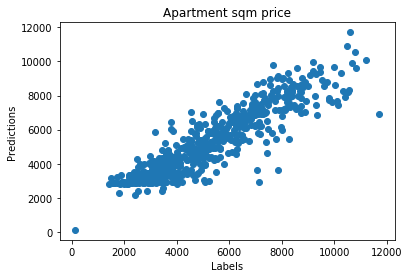

In [352]:
plt.scatter(labels_test, model.predict(features_test))
plt.xlabel('Labels')
plt.ylabel('Predictions')
plt.title('Apartment sqm price')

## Part n+1 

Choose relevant data
- house_type = kt (apartment building)
- condition = hyvä (good condition)
- elevator = on (has elevator)
- plot_ownership = oma (own plot)

In [129]:
avg_price_in_postal_code[df1.postal_code]

postal_code
00100    8702.550000
00100    8702.550000
00100    8702.550000
00100    8702.550000
00100    8702.550000
            ...     
00990    4957.264706
00990    4957.264706
00990    4957.264706
00990    4957.264706
00990    4957.264706
Name: price_per_sqm, Length: 535, dtype: float64

/Users/mathias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


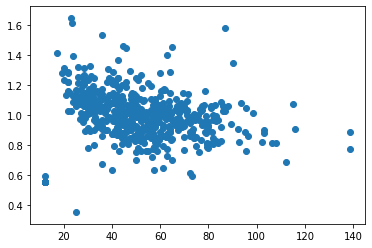

In [143]:
df1 = df[(df.house_type == 'kt') & (df.condition == 'hyvä') & (df.elevator == 'on') & (df.plot_ownership == 'oma')]

avg_price_in_postal_code = df1.groupby('postal_code').price_per_sqm.mean()

df1['normalized_sqm_price'] = np.zeros(len(df1))
df1.normalized_sqm_price = df1.price_per_sqm / avg_price_in_postal_code[df1.postal_code].values
#df1.price_per_sqm

plt.scatter(df1.sqm, df1.normalized_sqm_price)

Text(0, 0.5, 'Cost per sqm')

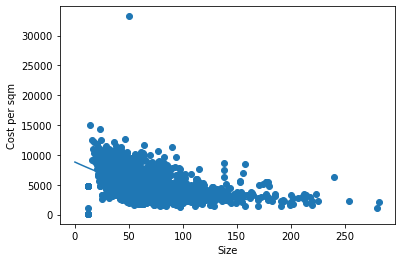

In [151]:
x = df.sqm.astype(float)
y = df.price_per_sqm.astype(float)
z = np.polyfit(x, y, 2)
p = np.poly1d(z)
s = np.linspace(0,160)

plt.scatter(x, y)
plt.plot(s, p(s))
plt.xlabel('Size')
plt.ylabel('Cost per sqm')

## Part n+1: Testing sklearn pipeline

In [395]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [415]:
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])



preprocessor = ColumnTransformer(
    transformers = [
        ('ord', ordinal_transformer, ordinal_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [416]:
model2 = RandomForestRegressor(n_estimators=100, random_state=0)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model2', model2)])
my_pipeline.fit(features_train, labels_train)

In [417]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model2', model2)])

In [418]:
my_pipeline.fit(features_train, labels_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ord',
                                                  Pipeline(memory=None,
                                                           steps=[('ordinal',
                                                                   OrdinalEncoder(categories='auto',
                                                                                  dtype=<class 'numpy.float64'>))],
                                                           verbose=False),
                                                  ['elevator', 'condition',
                                                   'plot_ownership']),
                                                 ('cat',
                                                  Pipeline

In [427]:
my_pipeline.predict(toolo_features)

array([8889.32982375])

In [422]:
features_train

,house_type,sqm,year_built,elevator,condition,plot_ownership,postal_code,floors,current_floor,floor_ratio
1512,kt,76.8,1971,on,tyyd.,vuokra,00630,4.0,3.0,0.75
2548,kt,30.0,1980,ei,tyyd.,oma,00960,3.0,3.0,1.00
593,kt,68.5,1946,on,tyyd.,oma,00270,7.0,7.0,1.00
2579,kt,68.7,1964,on,hyvä,oma,00960,5.0,3.0,0.60
2543,ok,140.0,1965,ei,tyyd.,oma,00950,1.0,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...
1762,kt,50.0,1969,on,hyvä,oma,00710,4.0,4.0,1.00
770,kt,55.2,1958,on,tyyd.,vuokra,00350,4.0,1.0,0.25
844,kt,47.5,2001,on,hyvä,oma,00380,5.0,4.0,0.80
1682,rt,97.0,1969,ei,tyyd.,oma,00680,1.0,1.0,1.00


In [479]:
harry = {'house_type' : ['rt'],
        'sqm': [75],
        'year_built': [2019],
        'elevator': ['ei'],
        'condition': ['hyvä'],
        'plot_ownership':['vuokra'],
        'postal_code':['02740'],
        'floors':[2],
        'current_floor':[2],
        'floor_ratio':[1]}

harry_features = pd.DataFrame.from_dict(toolo)

In [480]:
my_pipeline.predict(harry_features)

array([8840.28430655])